In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import researchpy as rp
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

from jupyterthemes import jtplot
jtplot.style(theme="grade3")

# Load Data

In [2]:
dataType = ["fastrtps_256", "fastrtps_128K", "opensplice_256", "opensplice_128K", "connext_256", "connext_128K"]

In [3]:
data = np.zeros([300, len(dataType)])
for i in range(len(dataType)):
    data[:, i] = np.loadtxt("./q4/"+str(dataType[i])+"byte.txt", dtype=np.float64) * 1000 # convert "s" to "ms"

data = data[30:, :]

# Make pd.Dataframe

In [4]:
fastrtps256 = pd.DataFrame(data[:, 0])
fastrtps128K = pd.DataFrame(data[:, 1])
opensplice256 = pd.DataFrame(data[:, 2])
opensplice128K = pd.DataFrame(data[:, 3])
connext256 = pd.DataFrame(data[:, 4])
connext128K = pd.DataFrame(data[:, 5])
df = [fastrtps256, fastrtps128K, opensplice256, opensplice128K, connext256, connext128K]

# Histogram Plot

In [5]:
def cap(x,quantile=[0.01,0.99]):
    """
    CAP Algorithm to delete the outliers
    
    Args：
        x：pd.Series
        quantile：upper/lower boundary in precentage
    """

    Q01,Q99=x.quantile(quantile).values.tolist()

    if Q01 > x.min():
        x = x.copy()
        x.loc[x<Q01] = Q01

    if Q99 < x.max():
        x = x.copy()
        x.loc[x>Q99] = Q99

    return(x)

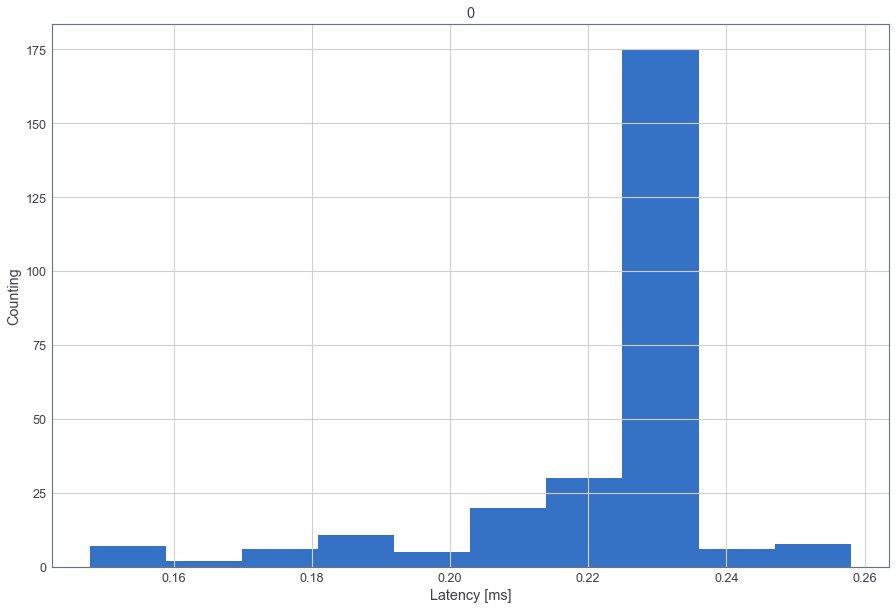

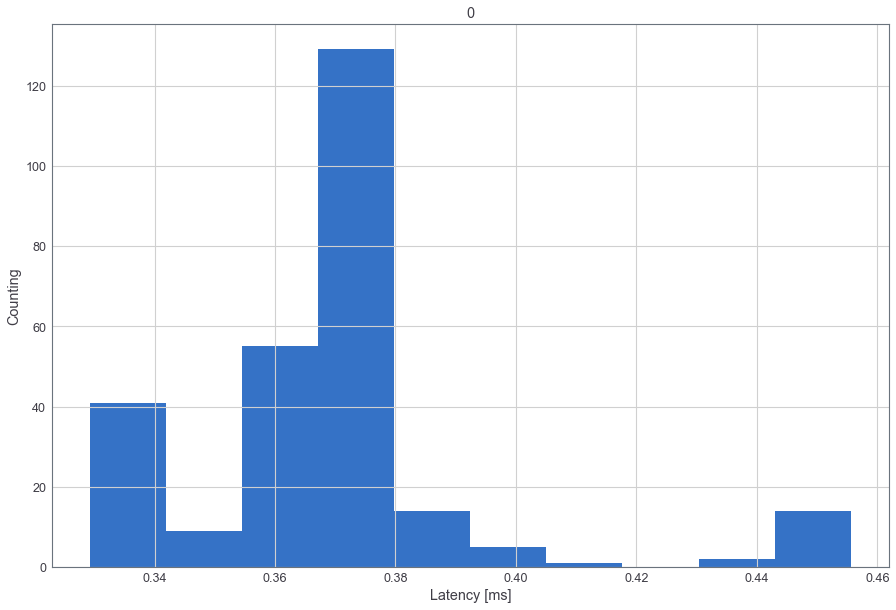

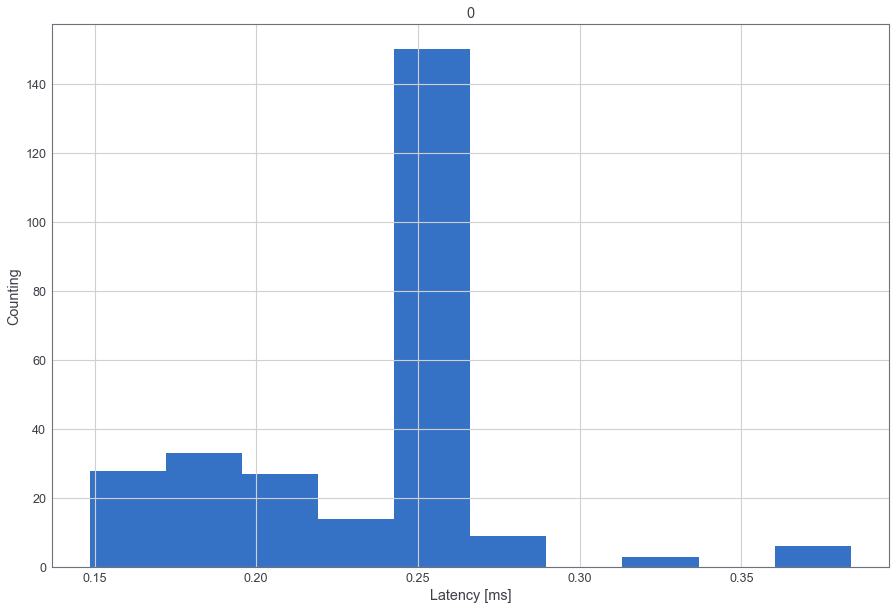

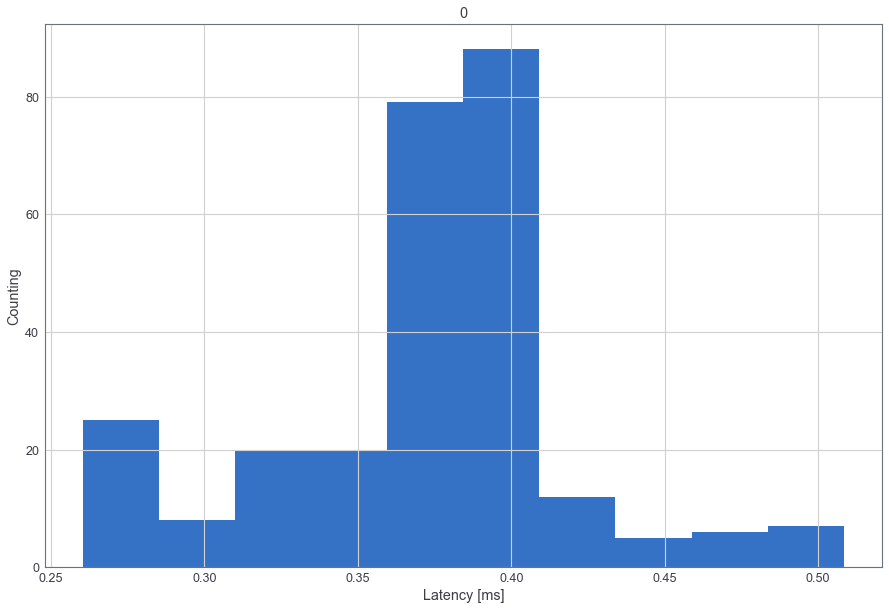

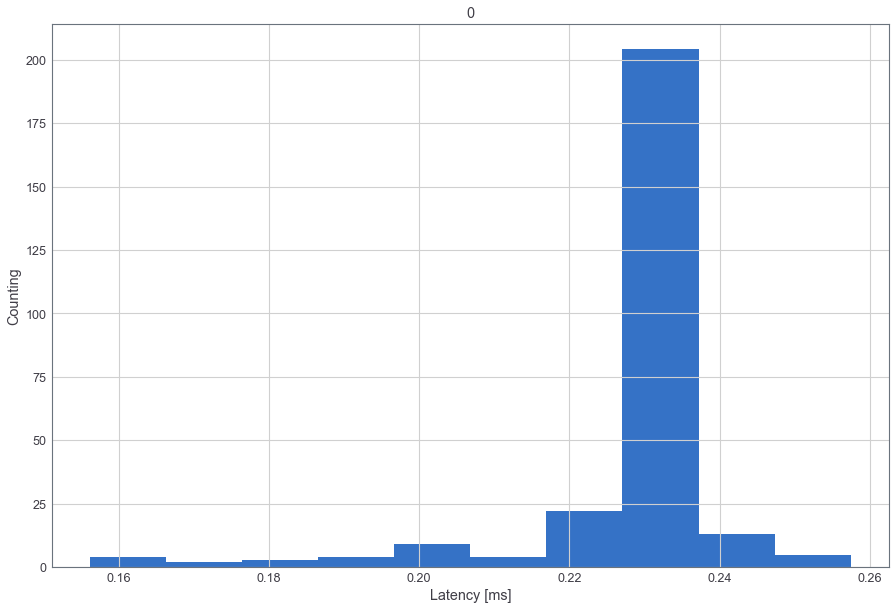

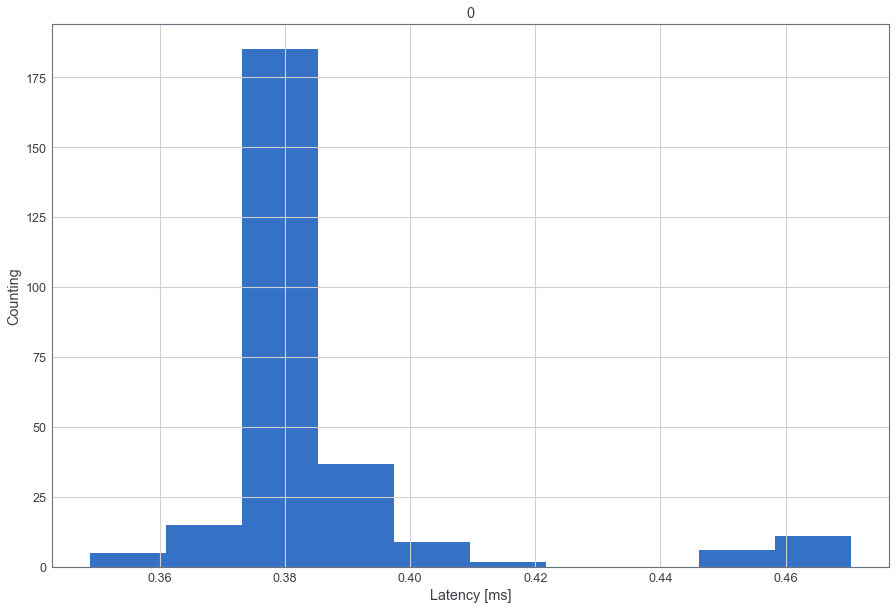

In [6]:
for i in range(6):
    temp = df[i].apply(cap, quantile=[0.01,0.99])
    boxfig = temp.hist(bins=10, figsize=(15,10))
    for axis in boxfig.flatten():
        axis.set_xlabel("Latency [ms]")
        axis.set_ylabel("Counting")
    plt.savefig("./q4/figure/"+dataType[i]+".png")

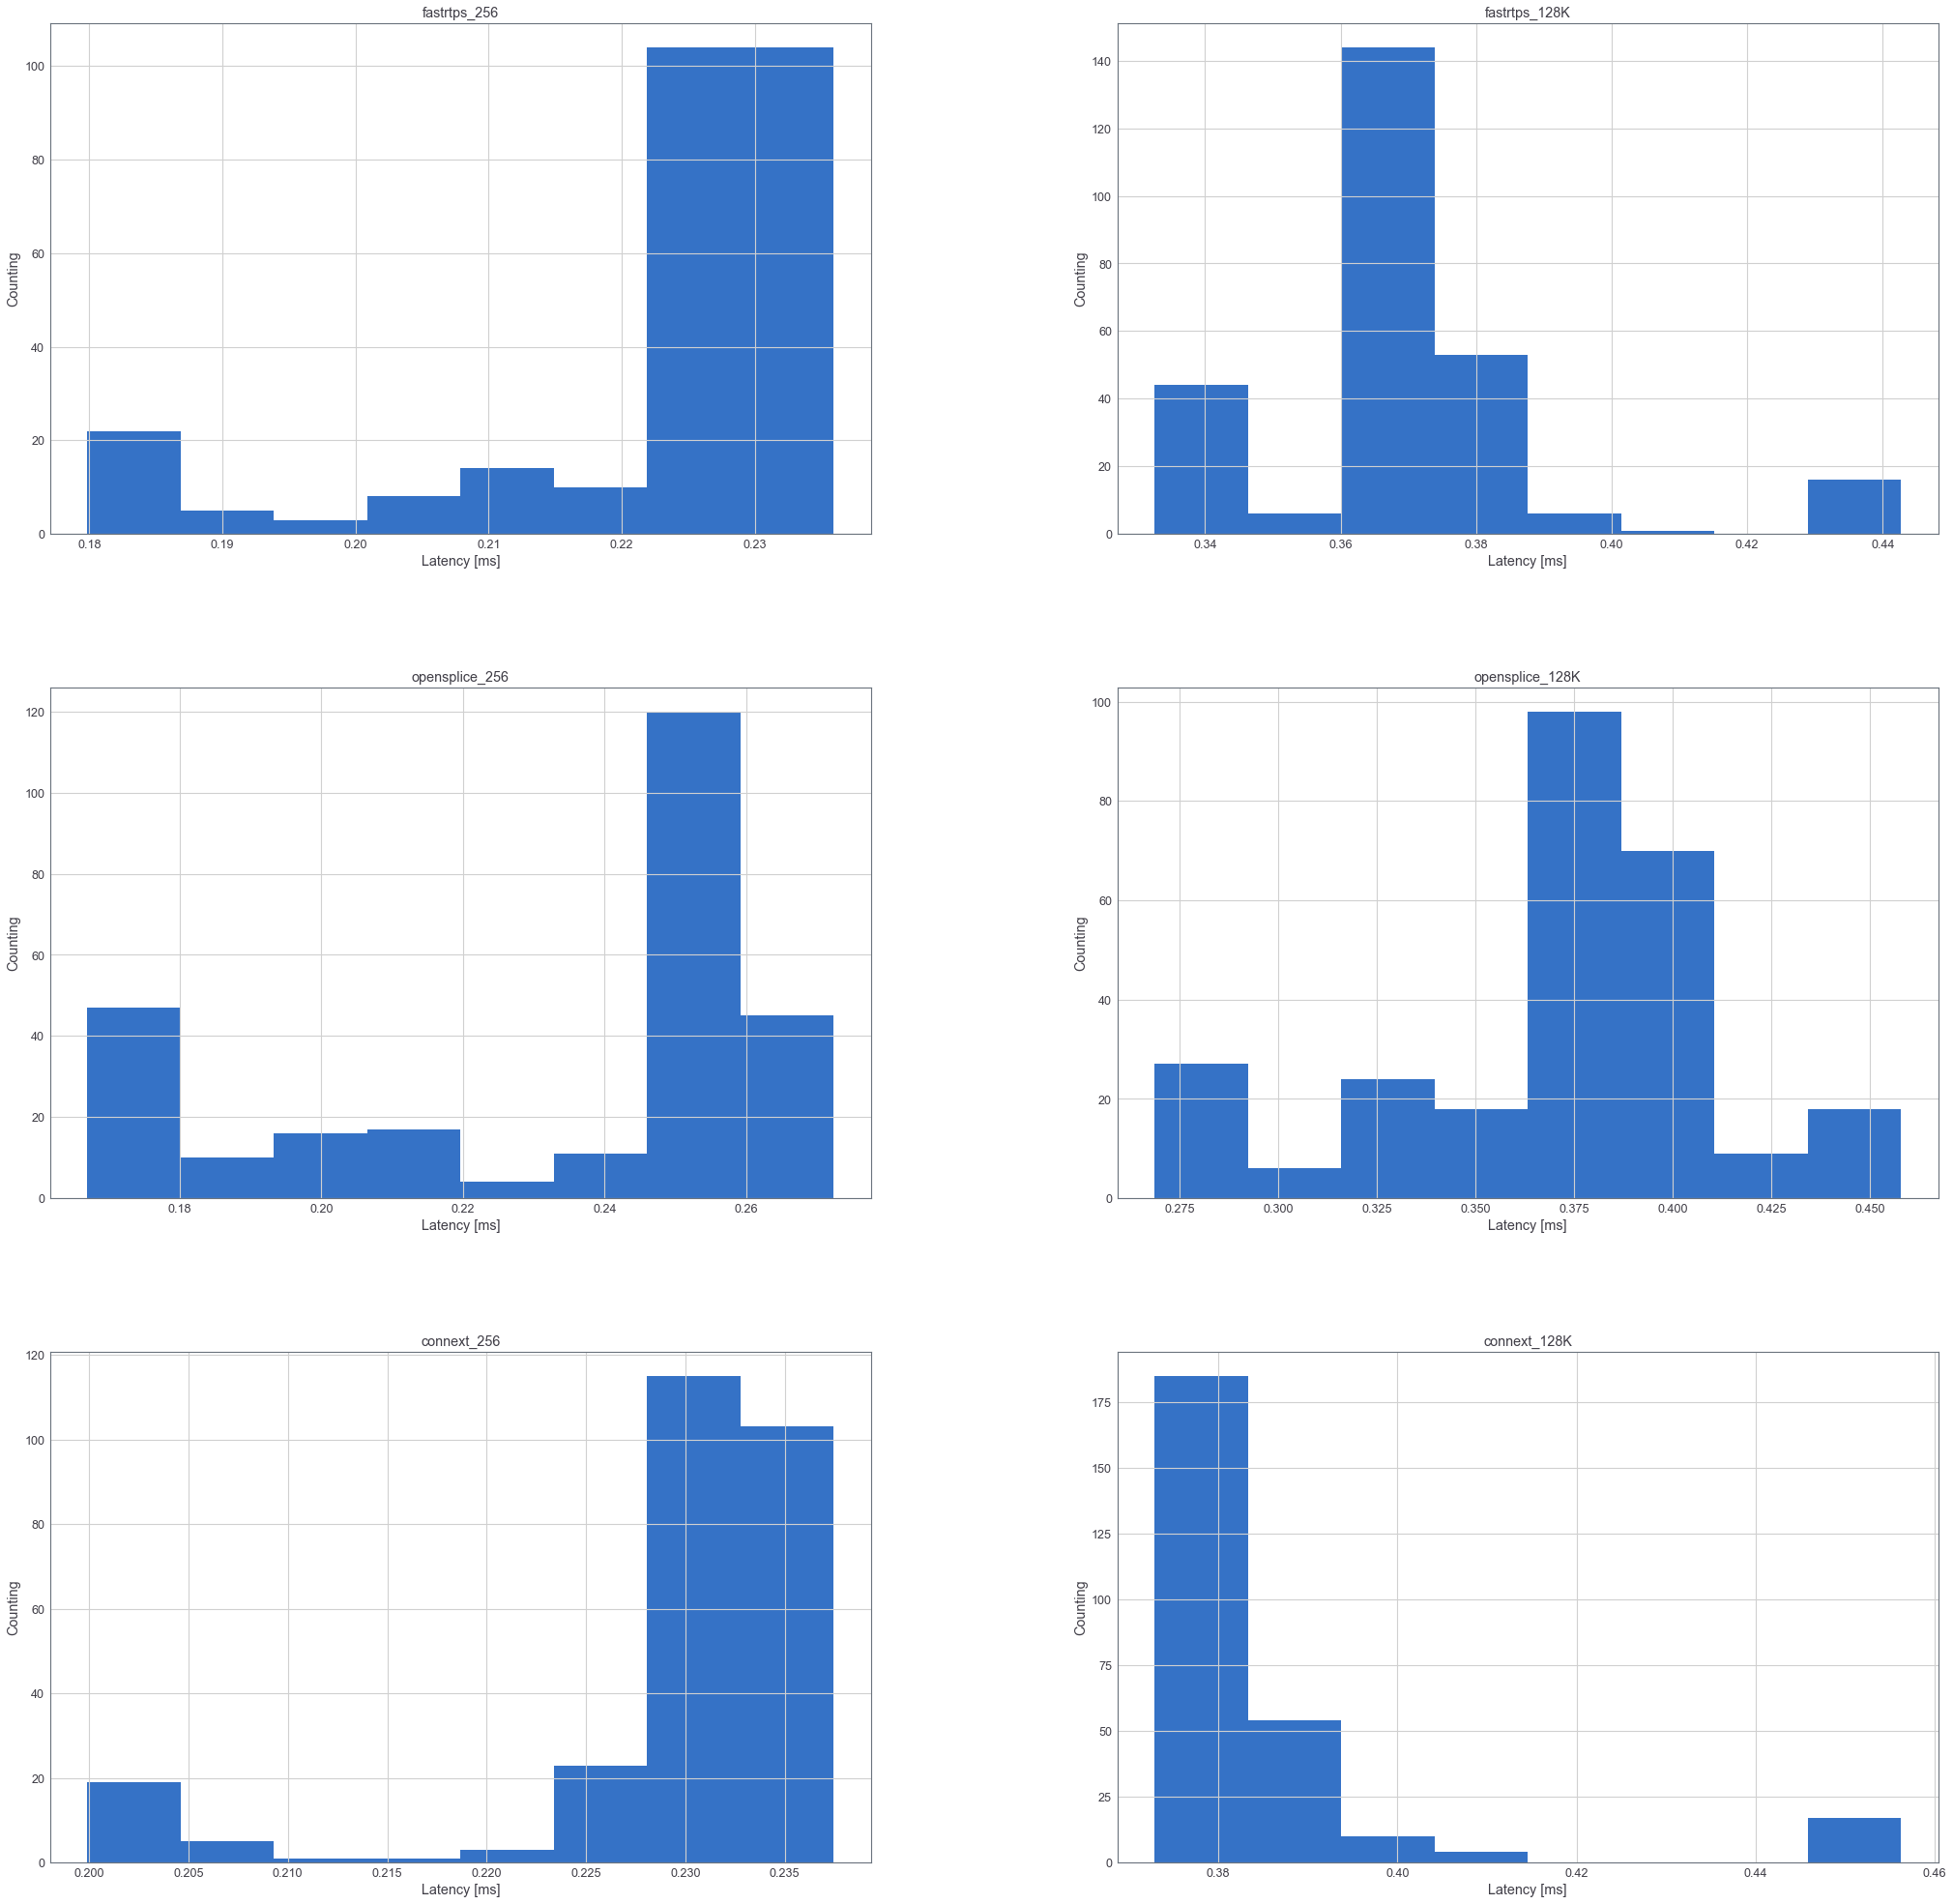

In [7]:
dfAll = pd.DataFrame(data, columns=dataType)
dfAll = dfAll.apply(cap, quantile=[0.05,0.95])
hisFigAll = dfAll.hist(bins=8, figsize=(35,35))
for axis in hisFigAll.flatten():
    axis.set_xlabel("Latency [ms]")
    axis.set_ylabel("Counting")
plt.savefig("./q4/figure/q4Hist.pdf", format="pdf", dpi=1200)

# Anova - Test

In [8]:
anova = pd.DataFrame({
    "latency": data.flatten("F"),
    "DDS": np.repeat(["fastrtps", "opensplice", "connext"], 2*270),
    "size": np.r_[np.repeat(["256B", "128KB"], 270),
                  np.repeat(["256B", "128KB"], 270),
                  np.repeat(["256B", "128KB"], 270)
                 ]
})

In [9]:
model_summary = rp.summary_cont(anova.groupby(['DDS', 'size']))['latency']
model_summary

N    Mean      SD      SE  95% Conf.  Interval
DDS        size                                                   
connext    128KB  270  0.3853  0.0221  0.0013     0.3826    0.3879
           256B   270  0.2285  0.0158  0.0010     0.2266    0.2304
fastrtps   128KB  270  0.3698  0.0256  0.0016     0.3667    0.3728
           256B   270  0.2222  0.0201  0.0012     0.2198    0.2246
opensplice 128KB  270  0.3728  0.0499  0.0030     0.3668    0.3788
           256B   270  0.2352  0.0487  0.0030     0.2293    0.2410

In [10]:
model_summary.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n           &      &    N &    Mean &      SD &      SE &  95\\% Conf. &  Interval \\\\\nDDS & size &      &         &         &         &            &           \\\\\n\\midrule\nconnext & 128KB &  270 &  0.3853 &  0.0221 &  0.0013 &     0.3826 &    0.3879 \\\\\n           & 256B &  270 &  0.2285 &  0.0158 &  0.0010 &     0.2266 &    0.2304 \\\\\nfastrtps & 128KB &  270 &  0.3698 &  0.0256 &  0.0016 &     0.3667 &    0.3728 \\\\\n           & 256B &  270 &  0.2222 &  0.0201 &  0.0012 &     0.2198 &    0.2246 \\\\\nopensplice & 128KB &  270 &  0.3728 &  0.0499 &  0.0030 &     0.3668 &    0.3788 \\\\\n           & 256B &  270 &  0.2352 &  0.0487 &  0.0030 &     0.2293 &    0.2410 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [11]:
model = ols('latency ~ C(DDS) + C(size) + C(DDS)*C(size)', anova).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 5, 1614) =  1594.492, p =  0.0000


In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                latency   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1594.
Date:                Thu, 10 Dec 2020   Prob (F-statistic):               0.00
Time:                        10:55:48   Log-Likelihood:                 3214.7
No. Observations:                1620   AIC:                            -6417.
Df Residuals:                    1614   BIC:                            -6385.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.3853      0.002    189.976      0.000       0.381       0.389
C(DDS)[T.fastrtps]                      -0.0155      0.003     -5.404      0.000      -0.021      -0.010
C(DDS)[T.opensplice]                    -0.0125      0.003     -4.343      0.000      -0.018      -0.007
C(size)[T.256B]                         -0.1568      0.003    -54.668      0.000      -0.162      -0.151
C(DDS)[T.fastrtps]:C(size)[T.256B]       0.0092      0.004      2.264      0.024       0.001       0.017
C(DDS)[T.opensplice]:C(size)[T.256B]     0.0191      0.004      4.716      0.000       0.011       0.027
==============================================================================
Omnibus:                      680.466   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22084.556
Skew:                           1.318   Prob(JB):                         0.00
Kurtosis:                      20.895   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
res = sm.stats.anova_lm(model, typ=2)
res

,sum_sq,df,F,PR(>F)
C(DDS),0.034492,2.0,15.530222,2.086354e-07
C(size),8.794003,1.0,7919.143846,0.000000e+00
C(DDS):C(size),0.024713,2.0,11.127291,1.586691e-05
Residual,1.792305,1614.0,NaN,NaN


In [14]:
res.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &    sum\\_sq &      df &            F &        PR(>F) \\\\\n\\midrule\nC(DDS)         &  0.034492 &     2.0 &    15.530222 &  2.086354e-07 \\\\\nC(size)        &  8.794003 &     1.0 &  7919.143846 &  0.000000e+00 \\\\\nC(DDS):C(size) &  0.024713 &     2.0 &    11.127291 &  1.586691e-05 \\\\\nResidual       &  1.792305 &  1614.0 &          NaN &           NaN \\\\\n\\bottomrule\n\\end{tabular}\n'